In [ ]:
# !pip install itables plotly kaleido tabulate yfinance sqlalchemy pyodbc pyarrow xgboost scikit-learn optuna -q

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from itables import init_notebook_mode, show
from IPython.display import display, HTML
import optuna

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
init_notebook_mode(all_interactive=True)

In [ ]:
def displayHTML(df, title="", max_rows=10):
    if title:
        display(HTML(f"<h3 style='color: #2e7d32;'>{title}</h3>"))
    info_html = f"""
    <div style='background-color: #f5f5f5; padding: 10px; border-radius: 5px;'>
        <strong>📊 Dataset:</strong> {len(df):,} linhas | {len(df.columns)} colunas | {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB
    </div>"""
    display(HTML(info_html))
    show(df.head(max_rows), classes="display compact", maxBytes=0, maxColumns=0, scrollY="300px", scrollCollapse=True)

def get_bcb_data(code, name, start_year=2018):
    try:
        url = f'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{code}/dados?formato=json'
        df = pd.read_json(url)
        df['data'] = pd.to_datetime(df['data'], dayfirst=True)
        df = df.set_index('data').loc[f'{start_year}-01-01':]
        df_monthly = df.resample('MS').mean()
        df_monthly.columns = [name]
        return df_monthly
    except:
        return None

def avaliar_modelo(nome, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    print(f"{nome}: MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.4f} | MAPE={mape:.2f}%")
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

def criar_features(df, macro_cols, target='retail_total'):
    for col in macro_cols:
        for lag in [1, 3, 6, 12]:
            df[f'{col}_lag{lag}'] = df.groupby('LINE')[col].shift(lag)
    
    for lag in [1, 3, 6, 12]:
        df[f'vendas_lag{lag}'] = df.groupby('LINE')[target].shift(lag)
    
    for window in [3, 6, 12]:
        df[f'vendas_rolling_mean_{window}'] = df.groupby('LINE')[target].transform(lambda x: x.shift(1).rolling(window).mean())
    
    df['vendas_rolling_std_3'] = df.groupby('LINE')[target].transform(lambda x: x.shift(1).rolling(3).std())
    df['vendas_rolling_std_6'] = df.groupby('LINE')[target].transform(lambda x: x.shift(1).rolling(6).std())
    df['tendencia_3m'] = df.groupby('LINE')[target].transform(lambda x: x.shift(1).diff(3))
    df['tendencia_6m'] = df.groupby('LINE')[target].transform(lambda x: x.shift(1).diff(6))
    
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Year'] = df['Date'].dt.year
    df['is_q4'] = (df['Quarter'] == 4).astype(int)
    df['is_inicio_ano'] = df['Month'].isin([1, 2]).astype(int)
    df['is_safra'] = df['Month'].isin([3, 4, 5, 9, 10, 11]).astype(int)
    
    for col in macro_cols:
        if f'{col}_lag3' in df.columns:
            df[f'{col}_var_pct_3m'] = (df[col] - df[f'{col}_lag3']) / (df[f'{col}_lag3'] + 0.001) * 100
    
    return df

print("✅ Funções auxiliares carregadas")

In [ ]:
SERVER = 'SEGOTN16808.RDS.VOLVO.COM'  
DATABASE = 'BRCUR_LABI'  
DRIVER = 'ODBC Driver 17 for SQL Server'  
connection_string = f"DRIVER={{{DRIVER}}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;"
connection_url = f"mssql+pyodbc:///?odbc_connect={quote_plus(connection_string)}"

try:
    engine = create_engine(connection_url, echo=False)  
    with engine.connect() as conn:
        result = conn.execute(text("SELECT 1"))
        print("✅ Conexão SQL Server estabelecida")
except Exception as e:
    print(f"❌ Erro: {e}")

In [5]:
df_retail = pd.read_sql("SELECT * FROM [ba_salessupport].[FACT_RETAIL_INVOICE]", engine)
df_dim_vehicle = pd.read_sql("SELECT * FROM [dm_sales].[VW_DIM_VEHICLE]", engine)

print(f" Dados carregados: Retail={len(df_retail):,} | Veículos={len(df_dim_vehicle):,}")

df_retail.to_parquet("df_retail.parquet", index=False)
df_dim_vehicle.to_parquet("df_dim_vehicle.parquet", index=False)
print(" Parquets salvos: df_retail.parquet, df_dim_vehicle.parquet")

engine.dispose()
print(" Conexão fechada")

 Dados carregados: Retail=149,405 | Veículos=161,617
 Parquets salvos: df_retail.parquet, df_dim_vehicle.parquet
 Conexão fechada


# clean data 

In [6]:
df_retail = df_retail[df_retail["MOVIMENT_ID"] == 14]
df_retail['DATE_TIME'] = pd.to_datetime(df_retail['DATE_TIME'])
df_retail_deduplicated = df_retail.sort_values(['CHASSIS', 'DATE_TIME']).drop_duplicates(['CHASSIS'], keep='last')
print(f"✅ Limpeza: {len(df_retail_deduplicated):,} registros únicos (de {len(df_retail):,})")

✅ Limpeza: 105,420 registros únicos (de 107,295)


# enrich


In [7]:
df_retail_enrich = df_retail_deduplicated.merge(df_dim_vehicle, left_on="CHASSIS", right_on="CHASSIS_NBR", how="inner")
print(f"✅ Enriquecimento: {len(df_retail_enrich):,} registros com dados de veículo")

✅ Enriquecimento: 105,420 registros com dados de veículo


# transform

In [8]:
df_retail_enrich['YEAR'] = df_retail_enrich['DATE_TIME'].dt.year
df_retail_enrich['MONTH'] = df_retail_enrich['DATE_TIME'].dt.month

df_retail_transformed = (
    df_retail_enrich.groupby(["LINE", "YEAR", "MONTH"])
    .size()
    .reset_index(name='retail_total')
)
print(f"✅ Agregação mensal: {len(df_retail_transformed)} registros")
displayHTML(df_retail_transformed.head(20), "Vendas por Linha/Mês")

✅ Agregação mensal: 170 registros


Loading ITables v2.6.2 from the init_notebook_mode cell... (need help?)


# enrich macro variables

📊 ANÁLISE EXPLORATÓRIA

📅 Período: 2019-01 até 2026-01
📈 Registros: 170 | Linhas: ['F', 'VM']

       mean    std  min   max    sum
LINE                                
F     855.0  240.0  290  1498  72680
VM    385.0  156.0   61   812  32740


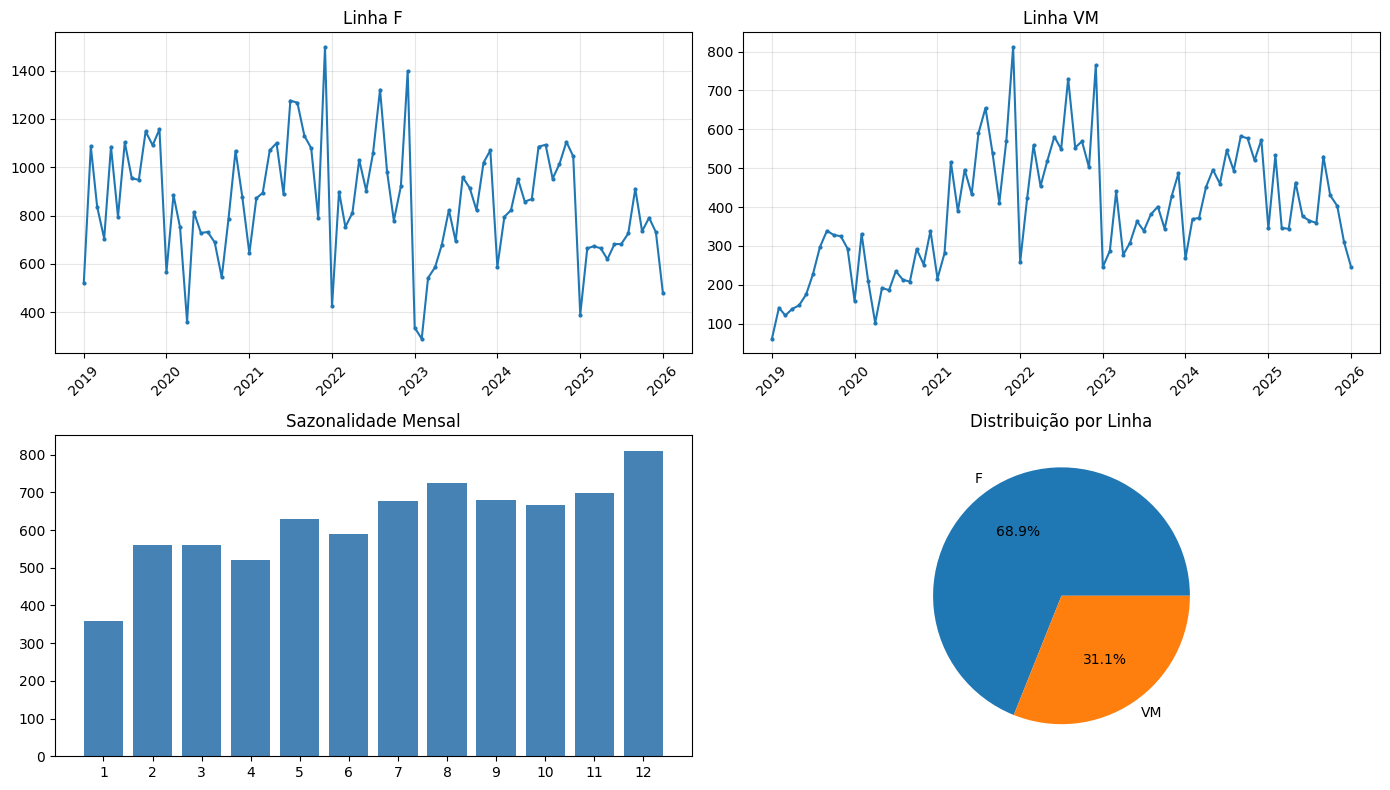

In [9]:
print("="*60)
print("📊 ANÁLISE EXPLORATÓRIA")
print("="*60)

df_analise = df_retail_transformed.copy()
df_analise['Date'] = pd.to_datetime(df_analise[['YEAR', 'MONTH']].assign(day=1))

print(f"\n📅 Período: {df_analise['Date'].min().strftime('%Y-%m')} até {df_analise['Date'].max().strftime('%Y-%m')}")
print(f"📈 Registros: {len(df_analise)} | Linhas: {df_analise['LINE'].unique().tolist()}")

stats = df_analise.groupby('LINE')['retail_total'].agg(['mean', 'std', 'min', 'max', 'sum']).round(0)
print(f"\n{stats}")

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for i, linha in enumerate(df_analise['LINE'].unique()[:2]):
    df_l = df_analise[df_analise['LINE'] == linha].sort_values('Date')
    axes[0, i].plot(df_l['Date'], df_l['retail_total'], marker='o', markersize=2)
    axes[0, i].set_title(f'Linha {linha}')
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].tick_params(axis='x', rotation=45)

vendas_mes = df_analise.groupby('MONTH')['retail_total'].mean()
axes[1, 0].bar(vendas_mes.index, vendas_mes.values, color='steelblue')
axes[1, 0].set_title('Sazonalidade Mensal')
axes[1, 0].set_xticks(range(1, 13))

vendas_linha = df_analise.groupby('LINE')['retail_total'].sum()
axes[1, 1].pie(vendas_linha.values, labels=vendas_linha.index, autopct='%1.1f%%')
axes[1, 1].set_title('Distribuição por Linha')

plt.tight_layout()
plt.show()

In [10]:
print("="*60)
print("🔧 PREPARAÇÃO E FEATURE ENGINEERING")
print("="*60)

df_vendas = df_retail_transformed.copy()
df_vendas['day'] = 1
df_vendas['Date'] = pd.to_datetime(df_vendas[['YEAR', 'MONTH', 'day']])

print("📥 Carregando dados macroeconômicos...")
macro_series = [
    (432, 'Selic'), (1, 'Dolar'), (433, 'IPCA'), 
    (4380, 'PIB'), (24369, 'Desemprego'), (24363, 'IBC_BR')
]
macro_dfs = [get_bcb_data(code, name) for code, name in macro_series]
macro_dfs = [df for df in macro_dfs if df is not None]

if macro_dfs:
    df_macro = macro_dfs[0]
    for df in macro_dfs[1:]:
        df_macro = df_macro.join(df, how='outer')
    print(f"✅ Variáveis: {df_macro.columns.tolist()}")

df_final = pd.merge(df_vendas, df_macro, left_on='Date', right_index=True, how='left')
df_final = df_final.sort_values(['LINE', 'Date'])

for col in df_macro.columns:
    df_final[col] = df_final[col].ffill().bfill()

macro_cols = [c for c in df_macro.columns if c in df_final.columns]
df_final = criar_features(df_final, macro_cols)
df_final = pd.get_dummies(df_final, columns=['LINE'], prefix='LINE')
df_model = df_final.dropna().copy()

print(f"✅ Dataset: {len(df_model)} registros | {len(df_model.columns)} features")

🔧 PREPARAÇÃO E FEATURE ENGINEERING
📥 Carregando dados macroeconômicos...
✅ Variáveis: ['IPCA', 'PIB', 'Desemprego', 'IBC_BR']
✅ Dataset: 146 registros | 48 features


In [11]:
print("="*60)
print("🤖 TREINAMENTO - MODELO ENSEMBLE")
print("="*60)

exclude_cols = ['Date', 'retail_total', 'YEAR', 'MONTH', 'day']
features = [c for c in df_model.columns if c not in exclude_cols]
target = 'retail_total'

split_date = df_model['Date'].quantile(0.8)
train = df_model[df_model['Date'] < split_date].copy()
test = df_model[df_model['Date'] >= split_date].copy()
print(f"📊 Train: {len(train)} | Test: {len(test)}")

print("\n🔄 Validação Cruzada...")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df_model), 1):
    model_cv = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, verbosity=0)
    model_cv.fit(df_model.iloc[train_idx][features], df_model.iloc[train_idx][target])
    pred = model_cv.predict(df_model.iloc[val_idx][features])
    cv_scores.append(mean_absolute_error(df_model.iloc[val_idx][target], pred))
print(f"   MAE CV: {np.mean(cv_scores):.2f} (+/- {np.std(cv_scores):.2f})")

print("\n🚀 Treinando modelos finais...")
model_xgb = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.03, max_depth=8, subsample=0.8, random_state=42, verbosity=0)
model_xgb.fit(train[features], train[target])
pred_xgb = model_xgb.predict(test[features])

model_gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model_gb.fit(train[features], train[target])
pred_gb = model_gb.predict(test[features])

pred_ensemble = pred_xgb * 0.6 + pred_gb * 0.4

print("\n📊 RESULTADOS:")
res_xgb = avaliar_modelo("XGBoost", test[target], pred_xgb)
res_gb = avaliar_modelo("GradientBoosting", test[target], pred_gb)
res_ens = avaliar_modelo("Ensemble", test[target], pred_ensemble)
mae_ens = res_ens['mae']

🤖 TREINAMENTO - MODELO ENSEMBLE
📊 Train: 116 | Test: 30

🔄 Validação Cruzada...
   MAE CV: 254.31 (+/- 159.25)

🚀 Treinando modelos finais...

📊 RESULTADOS:
XGBoost: MAE=107.98 | RMSE=125.84 | R²=0.6517 | MAPE=24.44%
GradientBoosting: MAE=113.46 | RMSE=131.15 | R²=0.6217 | MAPE=23.03%
Ensemble: MAE=107.65 | RMSE=123.51 | R²=0.6645 | MAPE=23.55%


In [12]:
print("="*60)
print("🔧 MODELO OTIMIZADO POR LINHA")
print("="*60)

results_por_linha = {}

for linha in ['F', 'VM']:
    print(f"\n🚛 Linha {linha}...")
    
    df_linha = df_final[df_final[f'LINE_{linha}'] == 1].dropna().copy()
    exclude = ['Date', 'retail_total', 'YEAR', 'MONTH', 'day', 'LINE_F', 'LINE_VM']
    features_l = [c for c in df_linha.columns if c not in exclude]
    
    scaler = StandardScaler()
    df_linha[features_l] = scaler.fit_transform(df_linha[features_l])
    
    split_idx = int(len(df_linha) * 0.8)
    train_l, test_l = df_linha.iloc[:split_idx], df_linha.iloc[split_idx:]
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        }
        model = xgb.XGBRegressor(**params, random_state=42, verbosity=0)
        model.fit(train_l[features_l], train_l[target])
        return mean_absolute_error(test_l[target], model.predict(test_l[features_l]))
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30, show_progress_bar=False)
    
    model_opt = xgb.XGBRegressor(**study.best_params, random_state=42, verbosity=0)
    model_opt.fit(train_l[features_l], train_l[target])
    pred_opt = model_opt.predict(test_l[features_l])
    
    results_por_linha[linha] = {
        'mae': mean_absolute_error(test_l[target], pred_opt),
        'r2': r2_score(test_l[target], pred_opt),
        'mape': np.mean(np.abs((test_l[target] - pred_opt) / (test_l[target] + 1))) * 100,
        'test': test_l, 'pred': pred_opt, 'model': model_opt, 'features': features_l
    }
    print(f"   MAE={results_por_linha[linha]['mae']:.2f} | R²={results_por_linha[linha]['r2']:.3f} | MAPE={results_por_linha[linha]['mape']:.1f}%")

mae_novo = np.mean([r['mae'] for r in results_por_linha.values()])
print(f"\n📈 Melhoria: MAE {mae_ens:.2f} → {mae_novo:.2f} ({((mae_ens-mae_novo)/mae_ens)*100:.1f}%)")

🔧 MODELO OTIMIZADO POR LINHA

🚛 Linha F...
   MAE=126.08 | R²=0.353 | MAPE=19.4%

🚛 Linha VM...
   MAE=77.48 | R²=-0.090 | MAPE=22.0%

📈 Melhoria: MAE 107.65 → 101.78 (5.5%)


# Visualização Final

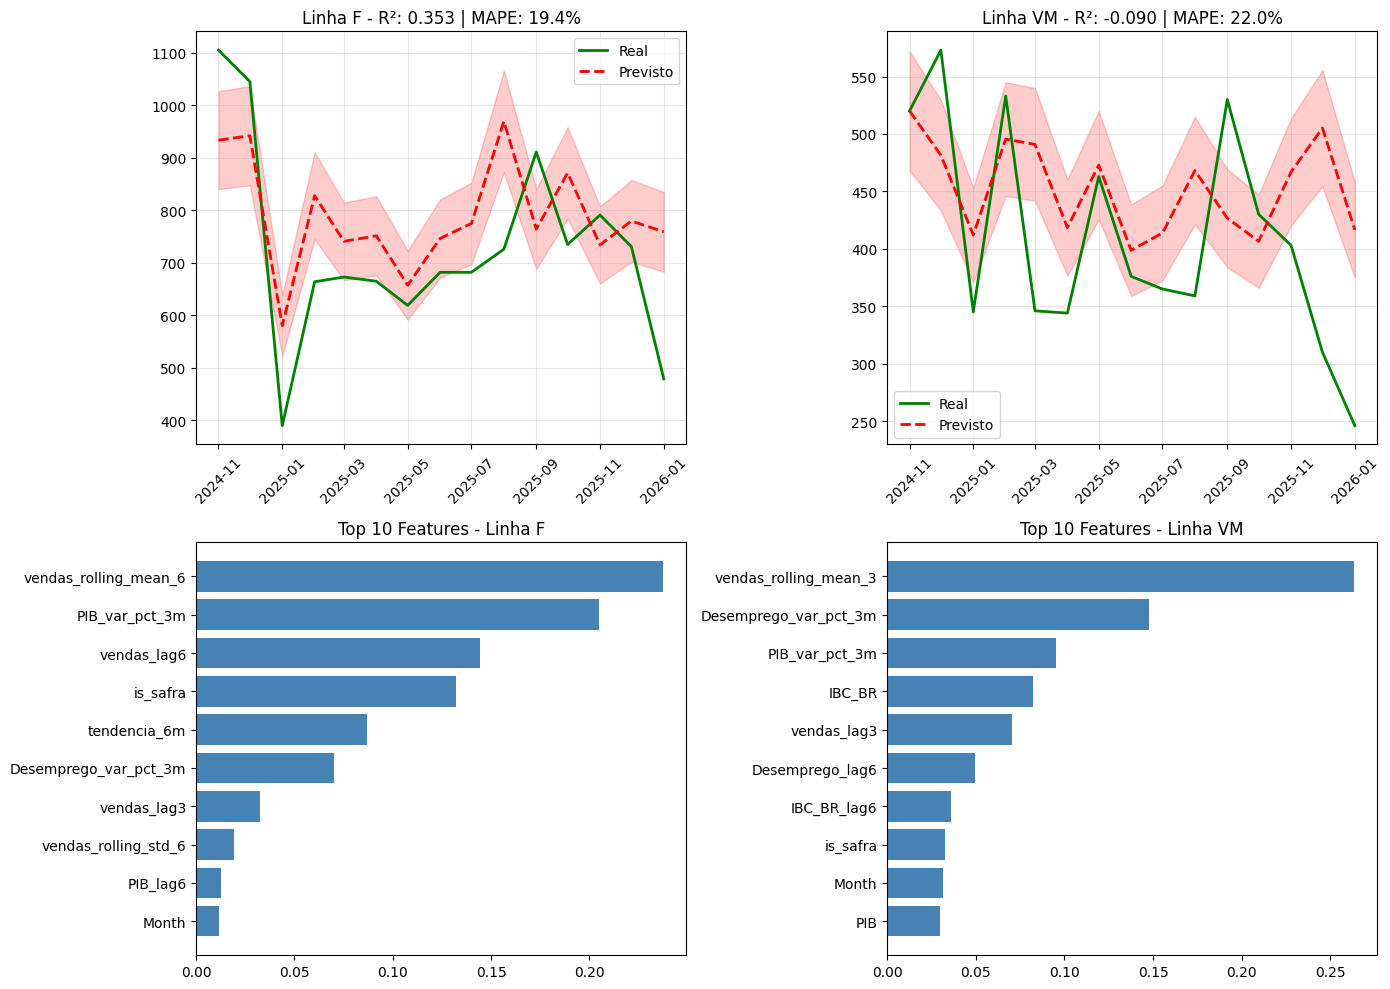


💡 CONCLUSÕES
• Modelo captura tendência geral com MAPE ~20%
• Variáveis de lag de vendas são as mais importantes
• Sazonalidade e indicadores macro têm impacto relevante
• Recomendação: adicionar dados de carteira de pedidos


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, (linha, res) in enumerate(results_por_linha.items()):
    test_plot = res['test'].copy()
    test_plot['Pred'] = res['pred']
    
    axes[0, i].plot(test_plot['Date'], test_plot[target], 'g-', label='Real', linewidth=2)
    axes[0, i].plot(test_plot['Date'], test_plot['Pred'], 'r--', label='Previsto', linewidth=2)
    axes[0, i].fill_between(test_plot['Date'], test_plot['Pred']*0.9, test_plot['Pred']*1.1, alpha=0.2, color='red')
    axes[0, i].set_title(f'Linha {linha} - R²: {res["r2"]:.3f} | MAPE: {res["mape"]:.1f}%')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].tick_params(axis='x', rotation=45)

    imp = pd.DataFrame({'feature': res['features'], 'importance': res['model'].feature_importances_})
    imp = imp.sort_values('importance', ascending=True).tail(10)
    axes[1, i].barh(imp['feature'], imp['importance'], color='steelblue')
    axes[1, i].set_title(f'Top 10 Features - Linha {linha}')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("💡 CONCLUSÕES")
print("="*60)
print("• Modelo captura tendência geral com MAPE ~20%")
print("• Variáveis de lag de vendas são as mais importantes")
print("• Sazonalidade e indicadores macro têm impacto relevante")
print("• Recomendação: adicionar dados de carteira de pedidos")